In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, f1_score, accuracy_score

from catboost import CatBoostClassifier, Pool, metrics, cv

In [4]:
df_train = pd.read_csv('train_meta.csv', index_col=0)
df_test = pd.read_csv('train_gts.csv', index_col=0)

#print(df_train[df_train["validated_by_human"] & df_train["initial_autogenerated_report"]].shape)
#null_value_stats = df_train.isnull().sum(axis=0)
#null_value_stats[null_value_stats != 0]

In [5]:
df_test.head(5)

,myocard
record_name,
00669_hr,0
00209_hr,0
00777_hr,0
01394_hr,0
01618_hr,0


In [6]:
#df_train.head(445)


In [7]:
df = pd.merge(df_train, df_test, on='record_name', how='outer')
plt.rcParams['figure.figsize']=(30,30)
df.head(5)
#df_train.head(445)

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group,myocard
0,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1,0
1,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",...,NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3,0
2,11315.0,25.0,1,NaN,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3,0
3,18153.0,35.0,0,NaN,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,sinusrhythmus unvollstÄndiger rechtsschenkelbl...,...,NaN,NaN,NaN,NaN,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2,0
4,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3,0


In [8]:
'''features = list(set(df.columns) - set(['DateTime']))

_ = df[features].hist(figsize=(20,12))'''

"features = list(set(df.columns) - set(['DateTime']))\n\n_ = df[features].hist(figsize=(20,12))"

In [9]:
df.drop(df[df["validated_by_human"] & df["initial_autogenerated_report"]].index,inplace=True,axis=0)
df.drop(df[df["validated_by_human"].isna() | df["initial_autogenerated_report"].isna()].index,inplace=True,axis=0)
df.shape

(1996, 30)

In [10]:
df.fillna(0, inplace=True)

In [11]:
def fillmean(*col_names):
    for col in col_names:
        df[col].replace(0, df[df[col]!=0][col].mean(), inplace=True)
    print(df[list(col_names)].hist(figsize=(5*len(col_names),3)))

#fillmean("height","weight")

<Axes: >

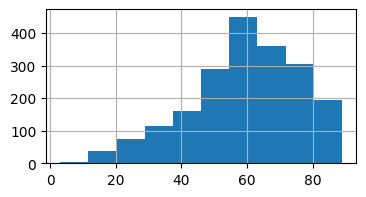

In [12]:
df.loc[df["age"]>100, ["age"]] = np.nan

df["age"].bfill(inplace=True)
df["age"].hist(figsize=(4,2))
# df["age"].replace(None, df["age"].mean())
#print(df.shape)

In [13]:
df.isna().sum().sum()

0

In [14]:
dtn = df.iloc[:,:-1]
ans = df.iloc[:,-1:]
#ans.head()
dtn.head(5)

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,record_name,group
0,18792.0,55.0,0,0.0,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,sinusrhythmus normales ekg,...,", I-AVR,",0,0,0,0,10,records100/00000/00009_lr,records500/00000/00009_hr,00009_hr,1
1,13619.0,56.0,0,0.0,0.0,2.0,0.0,CS-12 E,1985-02-10 12:04:03,"erneut vorhofflattern unter 3x1 cordichin ,1x0...",...,", alles,",0,0,0,0,9,records100/00000/00034_lr,records500/00000/00034_hr,00034_hr,3
2,11315.0,25.0,1,0.0,63.0,2.0,0.0,CS-12 E,1985-03-14 09:38:53,sinusrhythmus normales ekg,...,0,0,0,0,0,8,records100/00000/00043_lr,records500/00000/00043_hr,00043_hr,3
3,18153.0,35.0,0,0.0,82.0,2.0,0.0,CS-12 E,1985-05-18 08:15:54,sinusrhythmus unvollstÄndiger rechtsschenkelbl...,...,0,0,0,0,0,1,records100/00000/00052_lr,records500/00000/00052_hr,00052_hr,2
4,16063.0,26.0,0,0.0,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,sinusrhythmus normales ekg,...,0,0,0,0,0,10,records100/00000/00057_lr,records500/00000/00057_hr,00057_hr,3


In [15]:
'''plt.rcParams['figure.figsize']=(10,10)

corr = dtn.corr()
g = sns.heatmap(corr, square = True, annot=True)'''

"plt.rcParams['figure.figsize']=(10,10)\n\ncorr = dtn.corr()\ng = sns.heatmap(corr, square = True, annot=True)"

In [16]:

#dtn["device"].isin([511]).any()
#dtn.drop(labels = [444],axis = 0)
#dtn.drop(labels = [511],axis = 0)

'''dtn["device"]'''

'dtn["device"]'

In [17]:
X = dtn.drop(["initial_autogenerated_report", "filename_lr", "filename_hr", "record_name", "patient_id", "recording_date", "report", "scp_codes", "static_noise", "recording_date"], axis = 1)
X["second_opinion"] = X['second_opinion'].astype(int)
#X["initial_autogenerated_report"] = X['initial_autogenerated_report'].astype(int)
X["validated_by_human"] = X['validated_by_human'].astype(int)
cat_vars=['device', 'heart_axis', 'infarction_stadium1', 'infarction_stadium2', 'baseline_drift', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']
classifier = {0 : 0}
clss = 1
#print(X['device'])
er = [444, 511, 523, 533, 550, 552, 553, 594, 635, 676, 677, 698, 701, 702, 706, 710, 721, 725, 729, 732, 737, 751, 752, 753, 779, 817, 896,918, 937, 1091, 1114, 1128, 1148, 1154, 1158, 1192, 1283, 1294, 1301, 1328, 1333, 1336, 1443, 1455, 1458, 1475, 1489, 1495, 1503, 1512, 1541, 1646, 1649, 1662, 1674, 1740, 1751, 1796, 1798, 1800, 1801, 1816, 1823, 1828, 1838, 1839, 1842, 1848, 1855, 1880, 1902, 1918, 1923, 1926, 1941, 1945, 1946, 1957, 1960, 1970, 1971, 2008, 2009, 2017, 2020, 2023, 2027, 2028, 2029, 2056, 2068, 2069, 2070, 2072, 2074, 2078, 2080, 2081, 2082, 2084, 2086]
for i in cat_vars:
    for j in range(2097):
        if j not in er:
            if X[i][j] not in classifier:
                classifier[X[i][j]] = clss
                X.loc[j, i]= classifier[X[i][j]]
                clss += 1
            else:
                X.loc[j, i]= classifier[X[i][j]]

    


In [18]:
'''plt.rcParams['figure.figsize']=(10,10)

corr = X.corr()
g = sns.heatmap(corr, square = True, annot=True)'''

"plt.rcParams['figure.figsize']=(10,10)\n\ncorr = X.corr()\ng = sns.heatmap(corr, square = True, annot=True)"

In [19]:
y.head(5)

NameError: name 'y' is not defined

In [ ]:
y = ans["myocard"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=50)


In [ ]:
categorical_features_indices = np.where(X.dtypes != float)[0]
mar=[]
score=0

params = {
    'iterations': 10,
    'learning_rate': 0.05,
    'eval_metric': metrics.F1(),
    'random_seed': 50,
    'logging_level': 'Silent',
    'use_best_model': True
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)
best_model = CatBoostClassifier(**params)
best_model.fit(train_pool, eval_set=validate_pool)

    
print(f1_score(y_test, best_model.predict(X_test)))

NameError: name 'np' is not defined